# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../.."))

In [2]:
from belashovplot import TiledPlot, FontLibraryClass
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator, AbstractPropagator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator, Mask
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt, log10
import torch
import numpy
import pandas
from copy import deepcopy
from itertools import product
from typing import Iterable, Callable, Union
from cluster import train, confusion, execute, epochs

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8
FigureWidthHeight = (11.7, 16.5)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Определение параметров экспериметна

In [5]:
# Предпочтительные параметры
size = 9.765625E-6
near_N = 1024 #2004 #1336
near_length = 10.0E-3
wavelength = 500.0E-9
var = 8

# Параметры когерентности
spatial_coherence_range = numpy.sort(numpy.concatenate((numpy.linspace(15.0E-6, 3.0E-3, var), numpy.logspace(log10(5.0E-6), log10(15.0E-3), var))))
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 300

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = upper_integer(length*cppp / size)

# Параметры эксперимента
slit_width = size
slit_space_range = numpy.linspace(30.0E-6, 180.0E-6, 2*var)
distance_range = 0.5*length*numpy.sqrt((slit_space_range/(2*wavelength))**2 - 1.0)

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence_range[0].item(), 'м')} : {engineering(spatial_coherence_range[-1].item(), 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       1024
Количество пикселей маски:                1024
Размер оптических элементов:              10.0 мм
Размер пикселя маски:                     9.766 мкм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           5.0 мкм : 15.0 мм
Количество усреднений:                    300


# Инициализация эксперимента

In [6]:
propagators_list = []
incoherents_list = []
encoders_list = []
decoders_list = []
initials_list = []
for i, (slit_space, distance) in tqdm(enumerate(zip(slit_space_range, distance_range)), total=len(slit_space_range)):
    propagators_list.append(FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, border_ratio=0.8).cpu())
    initials_list.append((Window(centers=(-slit_space/2, 0), sizes=(slit_width, length))(*[torch.linspace(-length/2,+length/2,N)]*2) + Window(centers=(+slit_space/2, 0), sizes=(slit_width, length))(*[torch.linspace(-length/2,+length/2,N)]*2)).unsqueeze(0).unsqueeze(0).cpu())
for i, spatial_coherence in tqdm(enumerate(spatial_coherence_range), total=len(spatial_coherence_range)):
    incoherents_list.append(Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length))
    incoherents_list[-1].encoder.to(device)
    incoherents_list[-1].delayed.launch()
    encoders_list.append(incoherents_list[-1].encoder.cpu())
    decoders_list.append(incoherents_list[-1].decoder.cpu())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [13:04<00:00, 49.04s/it]


# Эксперимент

In [7]:
samples = torch.zeros((len(spatial_coherence_range), len(slit_space_range), N, N))
results = torch.zeros((len(spatial_coherence_range), len(slit_space_range), N, N))
results_meaned = torch.zeros((len(spatial_coherence_range), len(slit_space_range), N))

with torch.no_grad():
    for (col, (spatial_coherence, incoherent, encoder, decoder)), (row, (slit_space, distance, propagator, initial)) in tqdm(product(enumerate(zip(spatial_coherence_range, incoherents_list, encoders_list, decoders_list)), enumerate(zip(slit_space_range, distance_range, propagators_list, initials_list))), total=len(spatial_coherence_range)*len(slit_space_range)):
        torch.cuda.empty_cache()
        encoder, decoder, propagator, initial = encoder.to(device), decoder.to(device), propagator.to(device), initial.to(device)
        samples[col][row] = incoherent.sample()[0].cpu()
        
        field = decoder.forward(propagator.forward(encoder.forward(initial))).abs().squeeze().cpu()
        results[col][row] = field

        results_meaned[col][row] = torch.mean(field, dim=1)
        encoder, decoder, propagator, initial = encoder.cpu(), decoder.cpu(), propagator.cpu(), initial.cpu()

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [08:47<00:00,  2.06s/it]


# Отрисовка

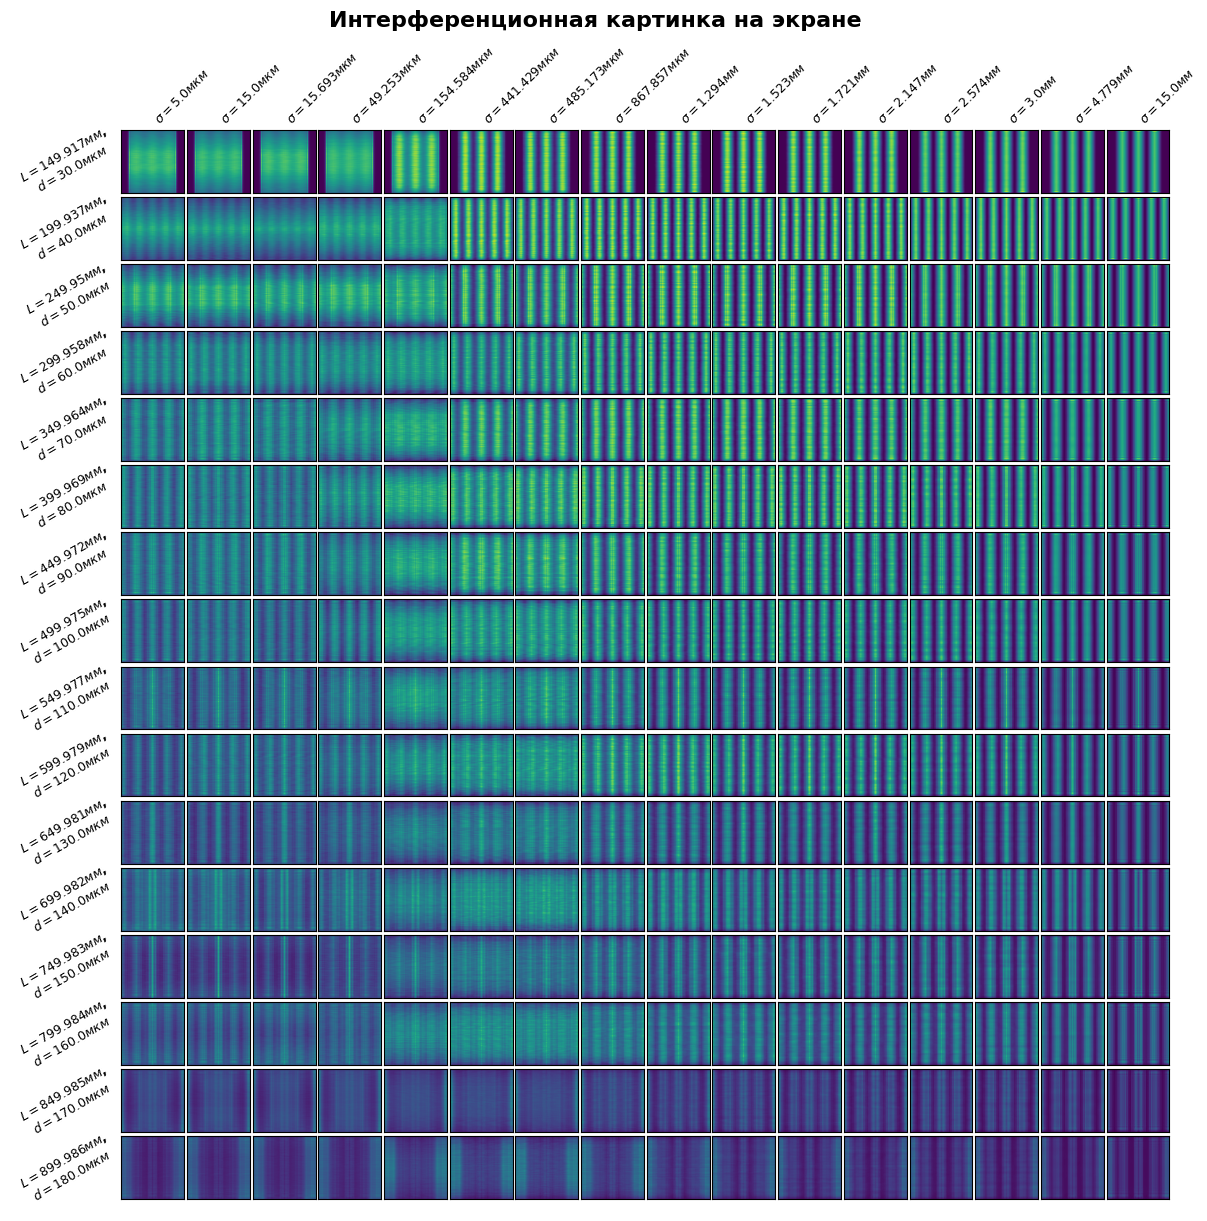

In [12]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.FontLibrary.Fonts.ColumnDescriptionTop.Rotation = 45
plot.FontLibrary.Fonts.ColumnDescriptionTop.HorizontalAlignment = 'left'
plot.FontLibrary.Fonts.RowDescriptionLeft.Rotation = 30

plot.title("Интерференционная картинка на экране")

for col, spatial_coherence in enumerate(spatial_coherence_range):
    plot.description.column.top(f"$\sigma={engineering(spatial_coherence, 'м', space='')}$", col)
for row, (slit_space, distance) in enumerate(zip(slit_space_range, distance_range)):
    plot.description.row.left(f"$L={engineering(distance,'м',space='')}$, $d={engineering(slit_space,'м',space='')}$", row)

for col, results_ in enumerate(results):
    for row, result in enumerate(results_):
        axes = plot.axes.add(col, row)
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.imshow(result.swapdims(0,1), aspect='auto')

plot.save("../../figures/ScreenInterference.svg")

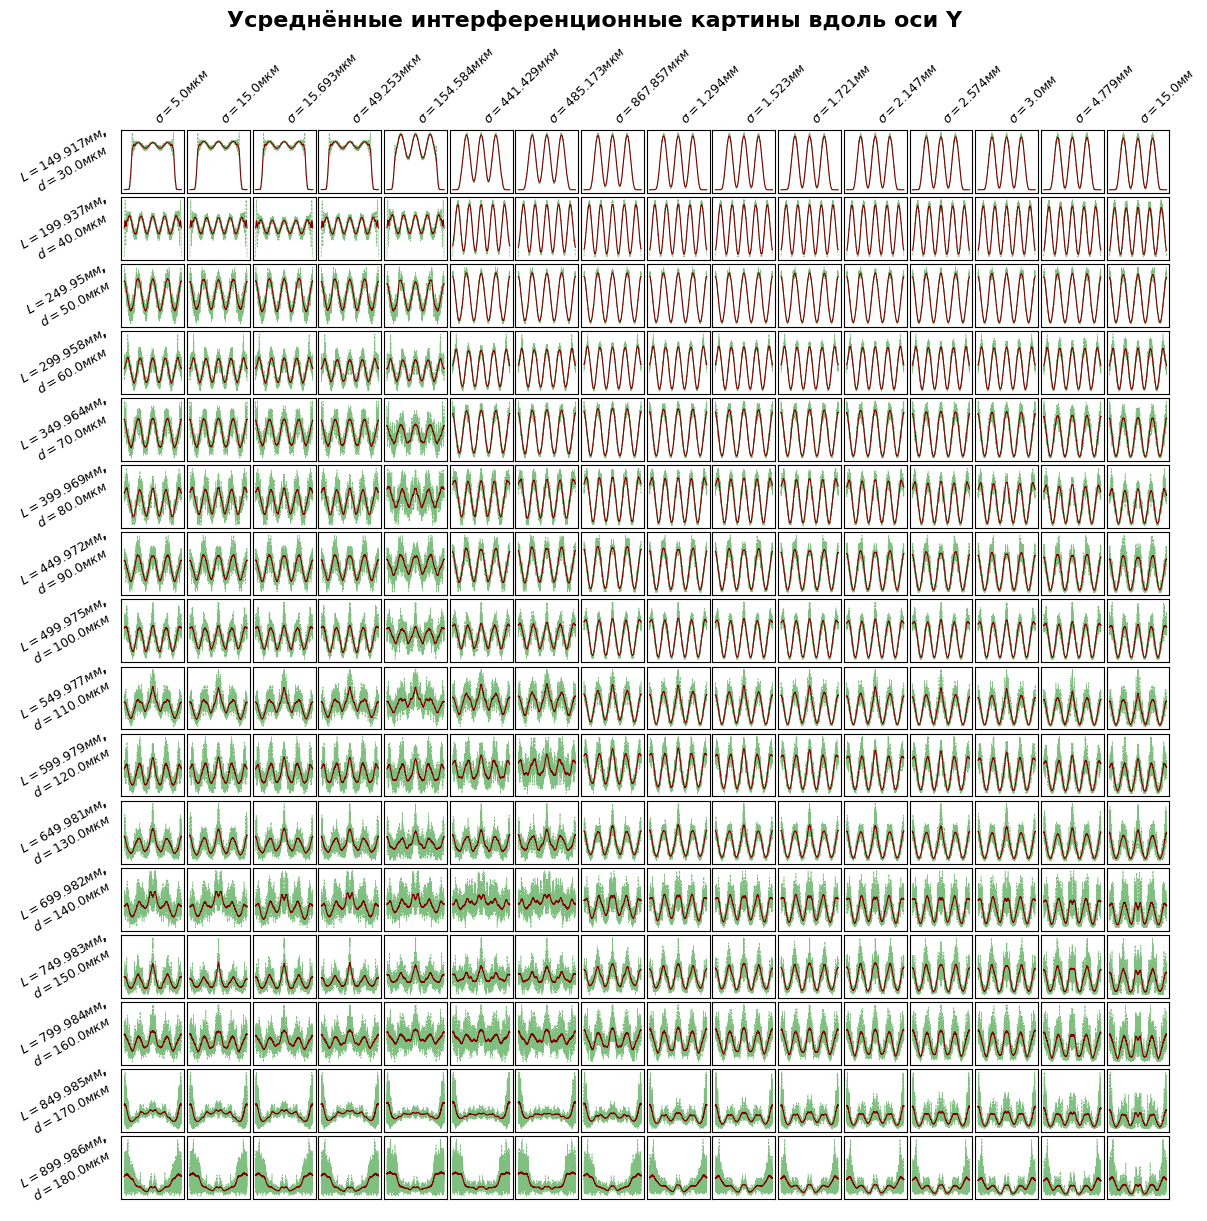

In [13]:
with torch.no_grad():
    results_meaned_furrier = torch.fft.fftshift(torch.fft.fft(results_meaned))
    window = 0.05
    window = int(results_meaned_furrier.shape[2]*window)
    window1 = N//2 - window//2
    window2 = window1 + window
    window = torch.zeros(1,1,results_meaned_furrier.shape[2])
    window[:,:,window1:window2] = 1.0 / (window2 - window1)
    window = torch.fft.fftshift(torch.fft.fft(window)).abs()
    results_meaned_filtered = torch.fft.ifft(torch.fft.ifftshift(results_meaned_furrier*window)).abs()


plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.FontLibrary.Fonts.ColumnDescriptionTop.Rotation = 45
plot.FontLibrary.Fonts.ColumnDescriptionTop.HorizontalAlignment = 'left'
plot.FontLibrary.Fonts.RowDescriptionLeft.Rotation = 30

plot.title("Усреднённые интерференционные картины вдоль оси Y")

for col, spatial_coherence in enumerate(spatial_coherence_range):
    plot.description.column.top(f"$\sigma={engineering(spatial_coherence, 'м', space='')}$", col)
for row, (slit_space, distance) in enumerate(zip(slit_space_range, distance_range)):
    plot.description.row.left(f"$L={engineering(distance,'м',space='')}$, $d={engineering(slit_space,'м',space='')}$", row)

for col, (results_meaned_filtered_, results_meaned_) in enumerate(zip(results_meaned_filtered, results_meaned)):
    for row, (result_meaned_filtered, result_meaned) in enumerate(zip(results_meaned_filtered_, results_meaned_)):
        axes = plot.axes.add(col, row)
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.plot(result_meaned, c='green', linewidth=0.5, linestyle='--', alpha=0.5)
        axes.plot(result_meaned_filtered, c='maroon', linewidth=0.8)
        axes.grid(True)

plot.save("../../figures/ScreenInterferenceMeaned.svg")

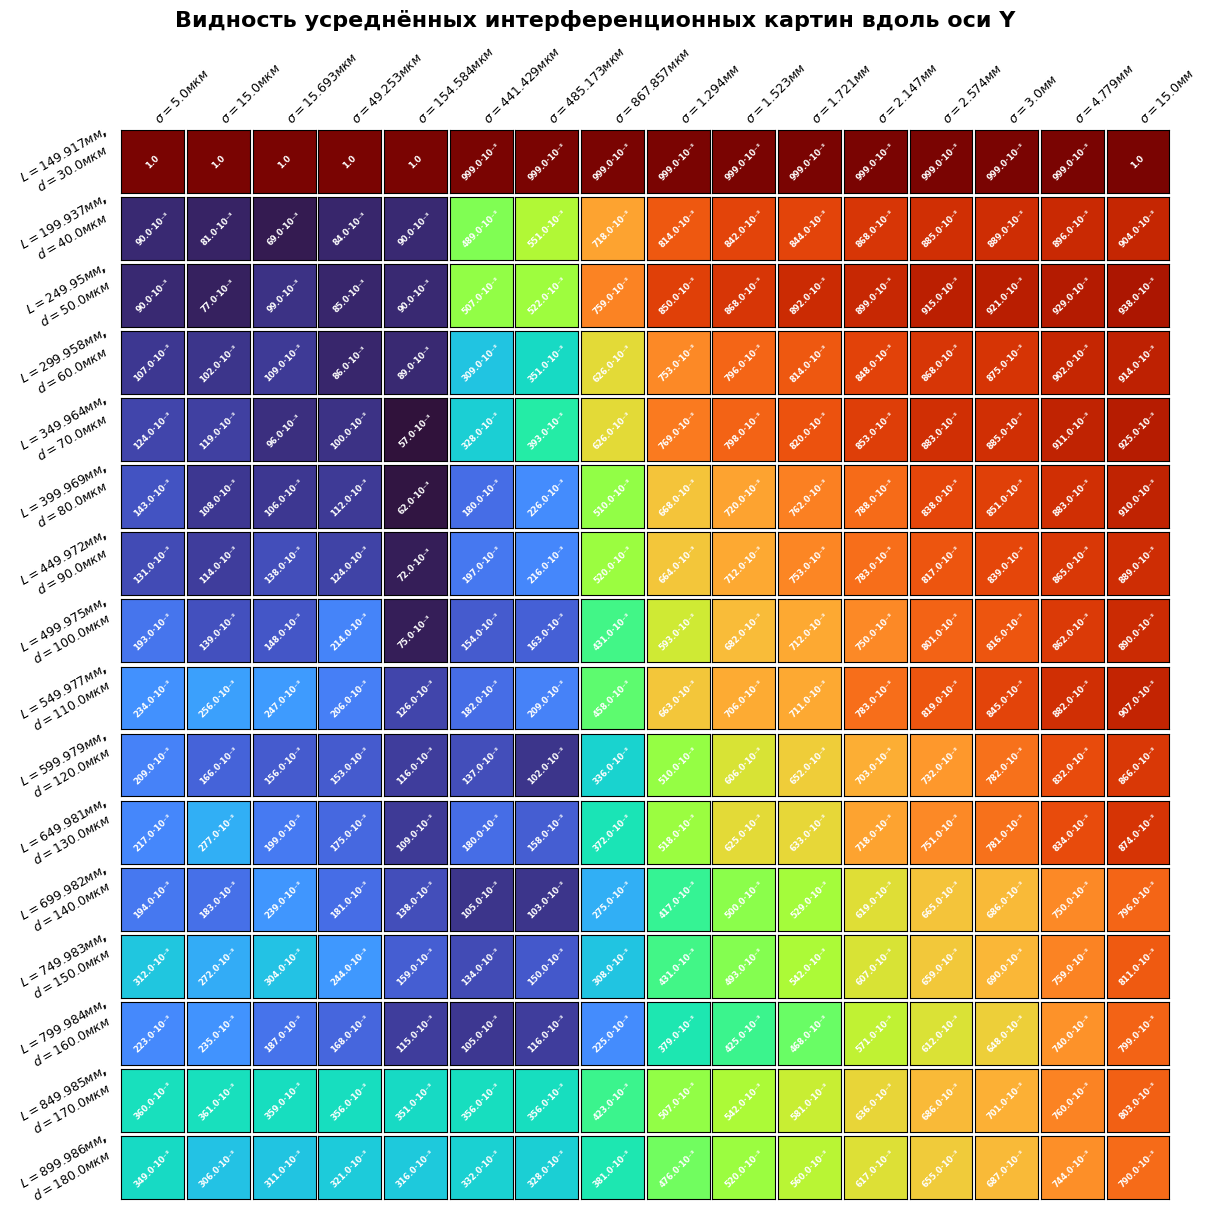

In [14]:
with torch.no_grad():
    maximums, _ = torch.max(results_meaned_filtered, dim=2)
    minimums, _ = torch.min(results_meaned_filtered, dim=2)
    visibilities = (maximums - minimums) / (maximums + minimums)
    visibilities_maximum = visibilities.max().item()
    visibilities_minimum = visibilities.min().item()


plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.FontLibrary.Fonts.ColumnDescriptionTop.Rotation = 45
plot.FontLibrary.Fonts.ColumnDescriptionTop.HorizontalAlignment = 'left'
plot.FontLibrary.Fonts.RowDescriptionLeft.Rotation = 30

plot.title("Видность усреднённых интерференционных картин вдоль оси Y")

for col, spatial_coherence in enumerate(spatial_coherence_range):
    plot.description.column.top(f"$\sigma={engineering(spatial_coherence, 'м', space='')}$", col)
for row, (slit_space, distance) in enumerate(zip(slit_space_range, distance_range)):
    plot.description.row.left(f"$L={engineering(distance,'м',space='')}$, $d={engineering(slit_space,'м',space='')}$", row)

for col, visibilities_ in enumerate(visibilities):
    for row, visibility in enumerate(visibilities_):
        axes = plot.axes.add(col, row)
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.imshow([[visibility]], vmin=visibilities_minimum, vmax=visibilities_maximum, cmap='turbo')
        axes.text(0., 0., scientific(round(visibility.item(), 3),'',0,space=''), verticalalignment='center', horizontalalignment='center', c='white', fontweight='bold', fontsize=6, rotation=45)

plot.save("../../figures/ScreenInterferenceVisibilities.svg")